In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cx_Oracle
from matplotlib import font_manager,rc
font_path = "/content/drive/MyDrive/L1/Notebooks/dataset/malgun.ttf"
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus']=False
%pwd

'/content'

In [6]:
# 입력값으로 oracle에 존재하는 테이블 명 입력 시 데이터프레임 생성 및 column 자동 설정
# return값은 데이터프레임

def call_orcl(tableName):
    # oracle 연결부
    # 접속 아이디, 비밀번호의 경우 각자의 설정에 맞게 변경
    db = cx_Oracle.connect('LMEMBER', 'LMEMBER', '121.139.63.229:1521/xepdb1')
    cursor = db.cursor()
    
    # 입력한 테이블명을 oracle에서 조회, 데이터프레임에 저장
    select_table_sql = "select * from " + tableName
    cursor.execute(select_table_sql)
    x = cursor.fetchall()
    df = pd.DataFrame(x)
    
    # 입력한 테이블명의 column 조회, 기존 데이터프레임의 column에 저장
    select_col_sql ="""select column_name from user_tab_columns 
    where table_name=:getTable"""
    cursor.execute(select_col_sql, getTable=tableName)
    col = cursor.fetchall()

    col_list = []
    for i in col:
        for j in i:
            col_list.append(j)

    df.columns = col_list
    cursor.close()
    db.commit()
    return df # 데이터프레임 return

In [7]:
# 개별 군집들의 평균 및 시각화 함수
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [8]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

## 전처리 (전체 데이터셋 생성)

In [9]:
df_origin=pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/full_data_with_label_FINAL.pkl')
df=df_origin.copy()
df.reset_index(inplace=True)
df

,CUSTNO,RECEIPTNO,PURCHDATE,PURCHTIME,AFFIL,CLASSCODEL,CLASSCODEM,CLASSCODES,STORENO,GENDER,AGEGROUP,RESIDENCE,PURCHAMOUNT,Year,AFFIL_CLASS,spent_less,AFFIL_CLASS_2,cloth_cat,hobby_cat,14purchase,15purchase
0,00001,02857006,2014-10-05,17,A,5,0506,A050601,012,M,60세이상,060,342400,2014,A5,0,A0506,cloth_men,uncategorized,342400,0
1,00001,02857007,2014-10-05,17,A,5,0506,A050601,012,M,60세이상,060,78000,2014,A5,0,A0506,cloth_men,uncategorized,78000,0
2,00001,02857020,2014-10-05,17,A,5,0501,A050113,012,M,60세이상,060,500000,2014,A5,0,A0501,cloth_men,uncategorized,500000,0
3,00001,02947490,2014-10-19,12,A,4,0402,A040222,012,M,60세이상,060,314640,2014,A4,0,A0402,cloth_casual,uncategorized,314640,0
4,00001,02947512,2014-10-19,13,A,5,0503,A050306,012,M,60세이상,060,406980,2014,A5,0,A0503,cloth_etc,uncategorized,406980,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339012,19373,02844688,2014-10-03,20,A,4,0402,A040228,042,F,25세~29세,100,69000,2014,A4,0,A0402,cloth_casual,uncategorized,69000,0
339013,19373,05366898,2015-10-25,14,A,4,0402,A040217,010,F,25세~29세,100,29000,2015,A4,0,A0402,cloth_casual,uncategorized,0,29000
339014,19373,05242502,2015-10-04,15,A,4,0402,A040217,042,F,25세~29세,100,69900,2015,A4,0,A0402,cloth_casual,uncategorized,0,69900
339015,19375,07268767,2014-11-14,22,B,33,3304,B330403,016,F,25세~29세,049,12800,2014,B33,1,B3304,cloth_lingerie,uncategorized,12800,0


In [10]:
a=df[['CUSTNO','PURCHTIME']]
a.groupby('CUSTNO')['PURCHTIME'].mean()

CUSTNO
00001    14.444444
00002    14.051282
00004    14.500000
00006    13.256410
00007    15.400000
           ...    
19369    18.058824
19371    15.000000
19372    15.369565
19373    17.000000
19375    20.000000
Name: PURCHTIME, Length: 16599, dtype: float64

In [11]:
ddf=pd.read_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/ddf_with_CUSTNO.pkl')
spent_less=ddf[['CUSTNO','spent_less']]
spent_less

,CUSTNO,spent_less
0,1,0.0
1,2,1.0
2,4,0.0
3,6,1.0
4,7,1.0
...,...,...
16290,19369,1.0
16291,19371,0.0
16292,19372,0.0
16293,19373,0.0


In [12]:
df['CUSTNO']=df['CUSTNO'].astype('int64')

In [13]:
custno=ddf.CUSTNO
edf=df[df.CUSTNO.isin(custno)]

In [14]:
edf_m=pd.merge(edf,spent_less,how='left',on='CUSTNO')
edf_m.rename({'spent_less_y':'spent_less'},axis=1,inplace=True)
edf_m['spent_less']=edf_m['spent_less'].astype('int64')
edf_m

,CUSTNO,RECEIPTNO,PURCHDATE,PURCHTIME,AFFIL,CLASSCODEL,CLASSCODEM,CLASSCODES,STORENO,GENDER,AGEGROUP,RESIDENCE,PURCHAMOUNT,Year,AFFIL_CLASS,spent_less_x,AFFIL_CLASS_2,cloth_cat,hobby_cat,14purchase,15purchase,spent_less
0,1,02857006,2014-10-05,17,A,5,0506,A050601,012,M,60세이상,060,342400,2014,A5,0,A0506,cloth_men,uncategorized,342400,0,0
1,1,02857007,2014-10-05,17,A,5,0506,A050601,012,M,60세이상,060,78000,2014,A5,0,A0506,cloth_men,uncategorized,78000,0,0
2,1,02857020,2014-10-05,17,A,5,0501,A050113,012,M,60세이상,060,500000,2014,A5,0,A0501,cloth_men,uncategorized,500000,0,0
3,1,02947490,2014-10-19,12,A,4,0402,A040222,012,M,60세이상,060,314640,2014,A4,0,A0402,cloth_casual,uncategorized,314640,0,0
4,1,02947512,2014-10-19,13,A,5,0503,A050306,012,M,60세이상,060,406980,2014,A5,0,A0503,cloth_etc,uncategorized,406980,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337918,19373,02844688,2014-10-03,20,A,4,0402,A040228,042,F,25세~29세,100,69000,2014,A4,0,A0402,cloth_casual,uncategorized,69000,0,0
337919,19373,05366898,2015-10-25,14,A,4,0402,A040217,010,F,25세~29세,100,29000,2015,A4,0,A0402,cloth_casual,uncategorized,0,29000,0
337920,19373,05242502,2015-10-04,15,A,4,0402,A040217,042,F,25세~29세,100,69900,2015,A4,0,A0402,cloth_casual,uncategorized,0,69900,0
337921,19375,07268767,2014-11-14,22,B,33,3304,B330403,016,F,25세~29세,049,12800,2014,B33,1,B3304,cloth_lingerie,uncategorized,12800,0,1


In [15]:
edf_m.to_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/final_data_set.pkl')

In [16]:
df_sl=edf_m[edf_m['spent_less']==1]
df_sl.drop('spent_less_x',axis=1,inplace=True)
df_sl

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CUSTNO,RECEIPTNO,PURCHDATE,PURCHTIME,AFFIL,CLASSCODEL,CLASSCODEM,CLASSCODES,STORENO,GENDER,AGEGROUP,RESIDENCE,PURCHAMOUNT,Year,AFFIL_CLASS,AFFIL_CLASS_2,cloth_cat,hobby_cat,14purchase,15purchase,spent_less
45,2,07587179,2014-10-22,17,B,27,2707,B270703,018,M,60세이상,100,20000,2014,B27,B2707,uncategorized,hobby_pet,20000,0,1
46,2,07587179,2014-10-22,17,B,27,2707,B270704,018,M,60세이상,100,10000,2014,B27,B2707,uncategorized,hobby_pet,10000,0,1
47,2,02931840,2014-10-17,15,A,4,0409,A040902,007,M,60세이상,100,504060,2014,A4,A0409,cloth_etc,uncategorized,504060,0,1
48,2,02723338,2014-09-14,17,A,6,0602,A060202,007,M,60세이상,100,560790,2014,A6,A0602,uncategorized,hobby_golf,560790,0,1
49,2,03163955,2014-11-22,12,A,6,0602,A060202,007,M,60세이상,100,290160,2014,A6,A0602,uncategorized,hobby_golf,290160,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337865,19369,10441595,2015-09-06,20,B,51,5105,B510501,110,F,45세~49세,047,111200,2015,B51,B5105,uncategorized,hobby_outdoor,0,111200,1
337866,19369,10441596,2015-09-06,20,B,51,5105,B510501,110,F,45세~49세,047,36000,2015,B51,B5105,uncategorized,hobby_outdoor,0,36000,1
337867,19369,07228035,2015-09-12,23,B,29,2904,B290404,014,F,45세~49세,047,19000,2015,B29,B2904,cloth_casual,uncategorized,0,19000,1
337921,19375,07268767,2014-11-14,22,B,33,3304,B330403,016,F,25세~29세,049,12800,2014,B33,B3304,cloth_lingerie,uncategorized,12800,0,1


## 군집분석 : 물리적 환경에 따른 분류

- 포함 요소

    - 성별

    - 나이

    - 지역

    - PURCHAMOUNT

In [17]:
# 전처리 ; RESIDENCE 결측치 치환
df_sl_14=df_sl[['CUSTNO','RESIDENCE','AGEGROUP','GENDER','PURCHAMOUNT']]
df_sl_14.reset_index(drop=True,inplace=True)
df_sl_14

,CUSTNO,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT
0,2,100,60세이상,M,20000
1,2,100,60세이상,M,10000
2,2,100,60세이상,M,504060
3,2,100,60세이상,M,560790
4,2,100,60세이상,M,290160
...,...,...,...,...,...
170135,19369,047,45세~49세,F,111200
170136,19369,047,45세~49세,F,36000
170137,19369,047,45세~49세,F,19000
170138,19375,049,25세~29세,F,12800


In [18]:
custno_storeno=pd.read_csv('/content/drive/MyDrive/L1/Notebooks/dataset/custno_storeno.csv')
storeno_residence=pd.read_csv('/content/drive/MyDrive/L1/Notebooks/dataset/storeno_residence.csv')
storeno_residence.rename(columns={'SOTRENO':'STORENO'},inplace=True)
custno_residence=pd.merge(custno_storeno,storeno_residence,how='left',on='STORENO')
custno_residence

,CUSTNO,STORENO,RESIDENCE
0,516,2,55
1,940,31,100
2,952,32,100
3,1084,9,100
4,1108,16,500
...,...,...,...
120,19233,37,100
121,19235,2,55
122,19288,1,100
123,19315,1,100


In [19]:
def get_null_res(x):
    if x['CUSTNO'] not in list(custno_residence['CUSTNO']):
        return x['RESIDENCE']
    for i in range(len(custno_residence)):
        if x['CUSTNO']==custno_residence['CUSTNO'][i]:
            return str(custno_residence['RESIDENCE'][i])
        else : continue
    
df_sl_14['RESIDENCE_new']=df_sl_14.apply(lambda x: get_null_res(x),axis=1)
df_sl_14.drop('RESIDENCE',axis=1,inplace=True)
df_sl_14.rename({'RESIDENCE_new':'RESIDENCE'},axis=1,inplace=True)
df_sl_14=df_sl_14[['CUSTNO','RESIDENCE','AGEGROUP','GENDER','PURCHAMOUNT']]
df_sl_14.RESIDENCE=df_sl_14.RESIDENCE.astype(int)
df_sl_14

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors

,CUSTNO,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT
0,2,100,60세이상,M,20000
1,2,100,60세이상,M,10000
2,2,100,60세이상,M,504060
3,2,100,60세이상,M,560790
4,2,100,60세이상,M,290160
...,...,...,...,...,...
170135,19369,47,45세~49세,F,111200
170136,19369,47,45세~49세,F,36000
170137,19369,47,45세~49세,F,19000
170138,19375,49,25세~29세,F,12800


In [20]:
df_sl_14.isnull().sum()

CUSTNO         0
RESIDENCE      0
AGEGROUP       0
GENDER         0
PURCHAMOUNT    0
dtype: int64

In [21]:
# GENDER와 AGEGROUP 레이블 인코딩
df_sl_14['AGEGROUP']=df_sl_14['AGEGROUP'].apply(lambda x: 0 if x=='19세이하'
                                           else 1 if x=='20세~24세'
                                           else 2 if x=='20세~24세'
                                           else 3 if x=='25세~29세'
                                           else 4 if x=='30세~34세'
                                           else 5 if x=='35세~39세'
                                           else 6 if x=='40세~44세'
                                           else 7 if x=='45세~49세'
                                           else 8 if x=='50세~54세'
                                           else 9 if x=='55세~59세'
                                           else 10 )
df_sl_14['GENDER']=df_sl_14['GENDER'].apply(lambda x: 0 if x=='M'
                                       else 1)
df_sl_14

,CUSTNO,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT
0,2,100,10,0,20000
1,2,100,10,0,10000
2,2,100,10,0,504060
3,2,100,10,0,560790
4,2,100,10,0,290160
...,...,...,...,...,...
170135,19369,47,7,1,111200
170136,19369,47,7,1,36000
170137,19369,47,7,1,19000
170138,19375,49,3,1,12800


In [22]:
df_sl_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170140 entries, 0 to 170139
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   CUSTNO       170140 non-null  int64
 1   RESIDENCE    170140 non-null  int64
 2   AGEGROUP     170140 non-null  int64
 3   GENDER       170140 non-null  int64
 4   PURCHAMOUNT  170140 non-null  int64
dtypes: int64(5)
memory usage: 6.5 MB


In [23]:
# 그룹화
aggregations={'RESIDENCE': lambda x : x.mode(),
              'AGEGROUP':'mean',
              'GENDER':'mean',
              'PURCHAMOUNT':'sum'}
df_sl_14_g=df_sl_14.groupby('CUSTNO').agg(aggregations)
df_sl_14_g

,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT
CUSTNO,,,,
2,100,10,0,13484940
6,240,10,1,2428700
7,36,10,1,19697570
11,100,10,0,6727450
16,460,10,1,428000
...,...,...,...,...
19362,16,7,1,4849760
19363,100,7,1,37700
19365,55,4,0,753120


(array([7.621e+03, 1.100e+01, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.50000000e+03, 7.04123640e+07, 1.40822228e+08, 2.11232092e+08,
        2.81641956e+08, 3.52051820e+08, 4.22461684e+08, 4.92871548e+08,
        5.63281412e+08, 6.33691276e+08, 7.04101140e+08]),
 <a list of 10 Patch objects>)

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


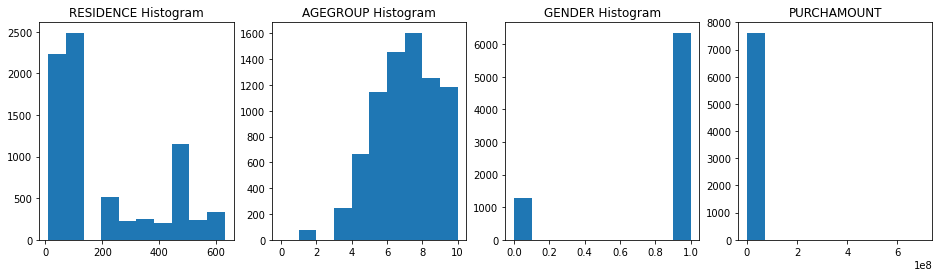

In [24]:
# 분포 살펴보기 위해 시각화 : log화 필요
fig,(ax1,ax2,ax3,ax4)=plt.subplots(figsize=(16,4),nrows=1,ncols=4)

ax1.set_title('RESIDENCE Histogram')
ax1.hist(df_sl_14_g['RESIDENCE'])

ax2.set_title('AGEGROUP Histogram')
ax2.hist(df_sl_14_g['AGEGROUP'])

ax3.set_title('GENDER Histogram')
ax3.hist(df_sl_14_g['GENDER'])

ax4.set_title('PURCHAMOUNT')
ax4.hist(df_sl_14_g['PURCHAMOUNT'])

(array([9.000e+00, 6.700e+01, 4.080e+02, 1.404e+03, 2.204e+03, 1.822e+03,
        1.349e+03, 3.430e+02, 2.700e+01, 2.000e+00]),
 array([ 7.82444593,  9.07924459, 10.33404326, 11.58884192, 12.84364059,
        14.09843925, 15.35323791, 16.60803658, 17.86283524, 19.11763391,
        20.37243257]),
 <a list of 10 Patch objects>)

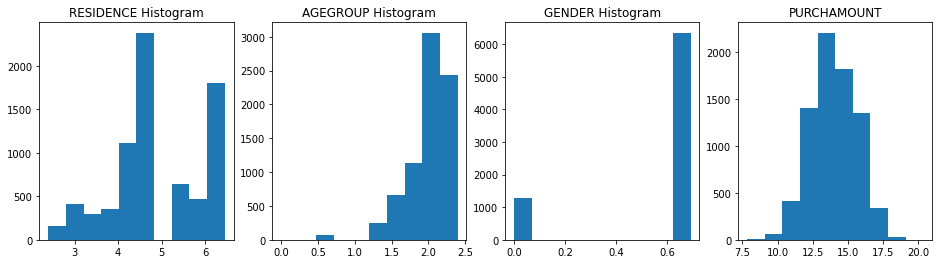

In [25]:
# 로그화 후 시각화 : StandardScaling 필요

df_sl_log=np.log1p(df_sl_14_g)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(figsize=(16,4),nrows=1,ncols=4)

ax1.set_title('RESIDENCE Histogram')
ax1.hist(df_sl_log['RESIDENCE'])

ax2.set_title('AGEGROUP Histogram')
ax2.hist(df_sl_log['AGEGROUP'])

ax3.set_title('GENDER Histogram')
ax3.hist(df_sl_log['GENDER'])

ax4.set_title('PURCHAMOUNT')
ax4.hist(df_sl_log['PURCHAMOUNT'])

(array([9.000e+00, 6.700e+01, 4.080e+02, 1.404e+03, 2.204e+03, 1.822e+03,
        1.349e+03, 3.430e+02, 2.700e+01, 2.000e+00]),
 array([-3.8314815 , -3.05361241, -2.27574331, -1.49787421, -0.72000511,
         0.05786399,  0.83573309,  1.61360219,  2.39147129,  3.16934039,
         3.94720949]),
 <a list of 10 Patch objects>)

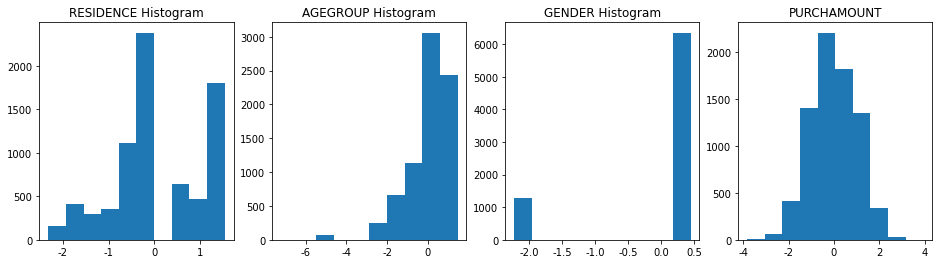

In [26]:
# Standeard Scaling 실시 후 시각화 : 정규성 회복은 되지 않았지만 스케일링은 의미가 있으므로
# Standard Scaling 실시
from sklearn.preprocessing import StandardScaler
df_sl_scaled_array=StandardScaler().fit_transform(df_sl_log)
df_sl_scaled=pd.DataFrame(df_sl_scaled_array,columns=df_sl_log.columns)

fig,(ax1,ax2,ax3,ax4)=plt.subplots(figsize=(16,4),nrows=1,ncols=4)

ax1.set_title('RESIDENCE Histogram')
ax1.hist(df_sl_scaled['RESIDENCE'])

ax2.set_title('AGEGROUP Histogram')
ax2.hist(df_sl_scaled['AGEGROUP'])

ax3.set_title('GENDER Histogram')
ax3.hist(df_sl_scaled['GENDER'])

ax4.set_title('PURCHAMOUNT')
ax4.hist(df_sl_scaled['PURCHAMOUNT'])

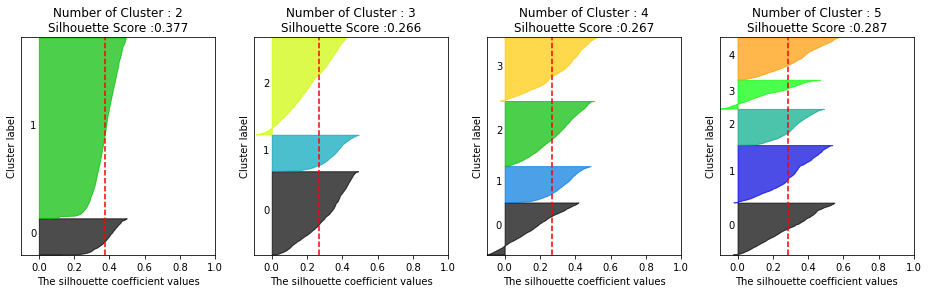

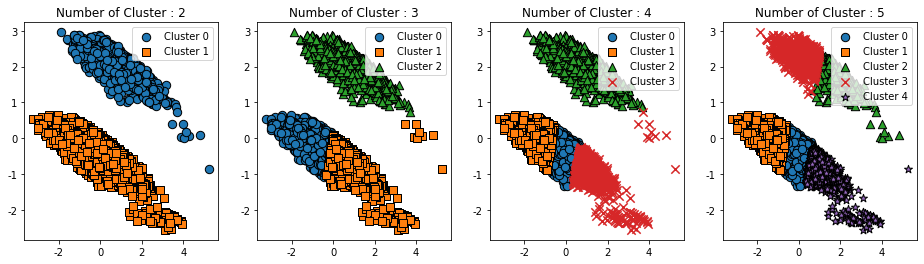

In [27]:
# clustering 실시

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

visualize_silhouette([2,3,4,5],df_sl_scaled)
visualize_kmeans_plot_multi([2,3,4,5],df_sl_scaled)

In [28]:
# Silhouette score 산출 및 cluster_label 생성
kmeans=KMeans(n_clusters=5,random_state=0)
labels=kmeans.fit_predict(df_sl_scaled)
df_sl_14_g['cluster_label']=labels
print('score : {:.3f}'.format(silhouette_score(df_sl_scaled,labels)))
df_sl_14_g

score : 0.287


,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT,cluster_label
CUSTNO,,,,,
2,100,10,0,13484940,2
6,240,10,1,2428700,4
7,36,10,1,19697570,1
11,100,10,0,6727450,2
16,460,10,1,428000,4
...,...,...,...,...,...
19362,16,7,1,4849760,1
19363,100,7,1,37700,0
19365,55,4,0,753120,2


In [29]:
# 각 cluster 성향 파악
aggregations={'RESIDENCE':'count',
              'AGEGROUP':'mean',
              'GENDER':'mean',
              'PURCHAMOUNT':'sum'}

d=df_sl_14_g.groupby('cluster_label').agg(aggregations).sort_values(by='PURCHAMOUNT',ascending=False)
d['RATIO']=(d['PURCHAMOUNT']/d['RESIDENCE'])*100
d.sort_values('RATIO',ascending=False)

,RESIDENCE,AGEGROUP,GENDER,PURCHAMOUNT,RATIO
cluster_label,,,,,
1,2026,7.322804,1.000000,15510813478,7.655880e+08
4,1481,6.770425,1.000000,7983888876,5.390877e+08
2,1270,6.525984,0.000000,4752030761,3.741757e+08
3,1020,3.837255,0.992157,1870377670,1.833704e+08
0,1838,7.235582,1.000000,618843930,3.366942e+07


## 남자가 하나의 cluster로 나오므로 남녀 분할해서 cluster 생성

In [54]:
sl_m=df_sl_14[df_sl_14.GENDER==0]
aggregations={'RESIDENCE':lambda x : x.mode(),
              'AGEGROUP':'mean',
              'PURCHAMOUNT':'sum'}
sl_m_g=sl_m.groupby('CUSTNO').agg(aggregations)
sl_m_g

,RESIDENCE,AGEGROUP,PURCHAMOUNT
CUSTNO,,,
2,100,10,13484940
11,100,10,6727450
17,43,10,900900
21,55,10,533770
24,43,10,1108300
...,...,...,...
19328,360,7,1421480
19329,610,6,211600
19334,310,5,198440


In [55]:
# scaling
sl_m_log=np.log1p(sl_m_g)
sl_m_scaled_array=StandardScaler().fit_transform(sl_m_log)
sl_m_scaled=pd.DataFrame(sl_m_scaled_array,columns=sl_m_g.columns)
sl_m_scaled

,RESIDENCE,AGEGROUP,PURCHAMOUNT
0,-0.340088,1.543482,1.600396
1,-0.340088,1.543482,1.162355
2,-1.149178,1.543482,-0.104158
3,-0.914355,1.543482,-0.433883
4,-1.149178,1.543482,0.026356
...,...,...,...
1273,0.900189,0.367467,0.183128
1274,1.412577,-0.125650,-1.016737
1275,0.755023,-0.694911,-1.057185
1276,-0.340088,-2.192250,-0.963118


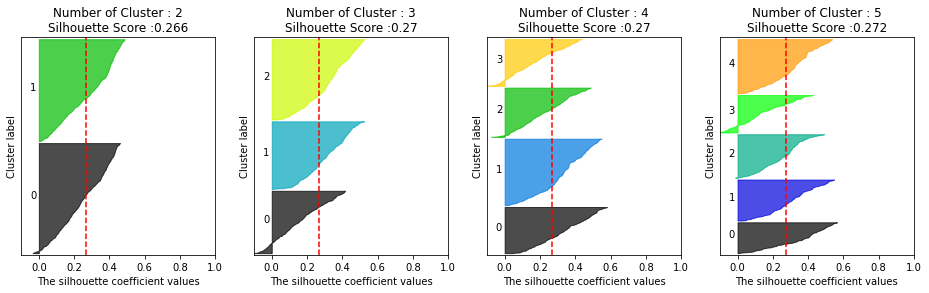

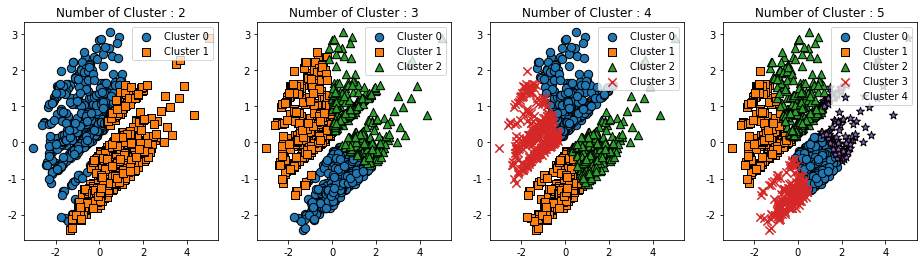

In [56]:
# Clustering
visualize_silhouette([2,3,4,5],sl_m_scaled)
visualize_kmeans_plot_multi([2,3,4,5],sl_m_scaled)

In [57]:
# Silhouette score 산출 및 cluster_label 생성
kmeans=KMeans(n_clusters=4,random_state=0)
labels=kmeans.fit_predict(sl_m_scaled)
sl_m_g['cluster_label']=labels
print('score : {:.3f}'.format(silhouette_score(sl_m_scaled,labels)))
sl_m_g.to_pickle('/content/drive/MyDrive/L1/Notebooks/dataset/clustering_men.pkl')
sl_m_g

score : 0.270


,RESIDENCE,AGEGROUP,PURCHAMOUNT,cluster_label
CUSTNO,,,,
2,100,10,13484940,1
11,100,10,6727450,1
17,43,10,900900,1
21,55,10,533770,1
24,43,10,1108300,1
...,...,...,...,...
19328,360,7,1421480,0
19329,610,6,211600,2
19334,310,5,198440,3


In [58]:
# 각 cluster 성향 파악
aggregations={'RESIDENCE':'count',
              'AGEGROUP':'mean',
              'PURCHAMOUNT':'sum'}

d=sl_m_g.groupby('cluster_label').agg(aggregations).sort_values(by='PURCHAMOUNT',ascending=False)
d['RATIO']=(d['PURCHAMOUNT']/d['RESIDENCE'])*100
d.sort_values('RATIO',ascending=False)

,RESIDENCE,AGEGROUP,PURCHAMOUNT,RATIO
cluster_label,,,,
1,407,7.316953,2879010774,7.073737e+08
0,283,6.901060,1466077385,5.180485e+08
3,286,4.171329,336925276,1.178060e+08
2,302,7.188742,75526876,2.500890e+07


In [59]:
# 성향 파악을 위한 사용자 함수 생성
def get_a(label,attribution1,attribution2):
    print('##### '+attribution1+' #####')
    print(np.sort(sl_m_g[sl_m_g['cluster_label']==label][attribution1].unique()))
    print()
    print('##### '+attribution2+' #####')
    print(np.sort(sl_m_g[sl_m_g['cluster_label']==label][attribution2].unique()))
    print()
    fig,(ax1,ax2)=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
    ax1.set_title(attribution1+' histogram')
    sns.histplot(sl_m_g[sl_m_g['cluster_label']==label][attribution1],ax=ax1)
    ax2.set_title(attribution2+' histogram')
    sns.histplot(sl_m_g[sl_m_g['cluster_label']==label][attribution2],ax=ax2,bins=7)

##### RESIDENCE #####
[ 10  13  16  20  24  27  30  33  36  39  43  45  47  49  52  55  60  65
  69  72  87 100]

##### AGEGROUP #####
[ 4  5  6  7  8  9 10]



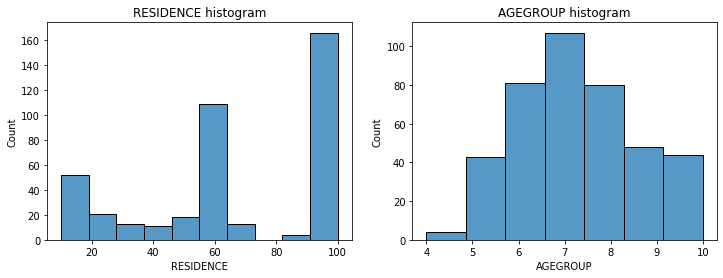

In [65]:
get_a(1,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[210 270 300 310 340 360 410 440 460 500 540 570 610 630]

##### AGEGROUP #####
[ 4  5  6  7  8  9 10]



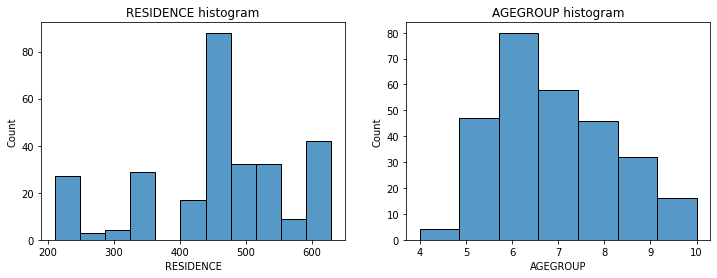

In [66]:
get_a(0,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[ 10  13  16  24  33  36  43  47  49  52  55  60  65  75  82  85  87 100
 210 240 270 300 310 340 360 410 440 460 500 540 570 610]

##### AGEGROUP #####
[0 1 3 4 5]



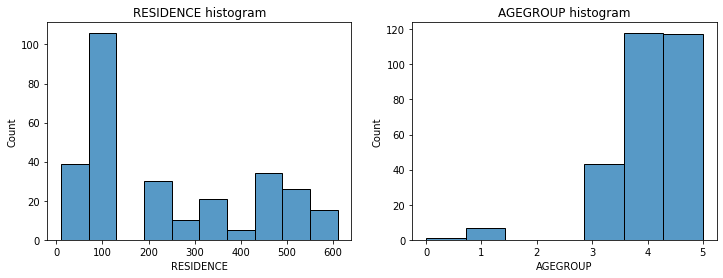

In [67]:
get_a(3,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[ 13  16  24  30  36  39  45  47  49  52  55  60  65  69  75  82 100 210
 240 270 310 340 360 410 440 460 500 540 570 610]

##### AGEGROUP #####
[ 5  6  7  8  9 10]



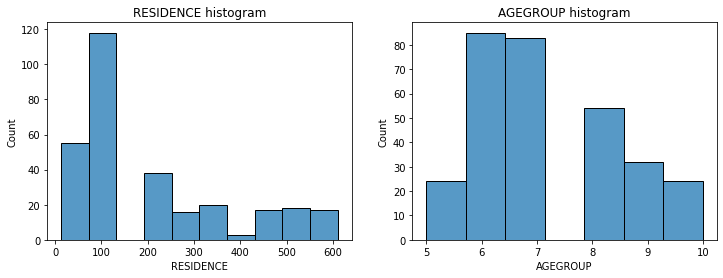

In [69]:
get_a(2,'RESIDENCE','AGEGROUP')

## 여성만 따로 분류하여 clustering

In [41]:
sl_w=df_sl_14[df_sl_14.GENDER==1]
aggregations={'RESIDENCE':lambda x : x.mode(),
              'AGEGROUP':'mean',
              'PURCHAMOUNT':'sum'}
sl_w_g=sl_w.groupby('CUSTNO').agg(aggregations)
sl_w_g

,RESIDENCE,AGEGROUP,PURCHAMOUNT
CUSTNO,,,
6,240,10,2428700
7,36,10,19697570
16,460,10,428000
25,460,10,6966250
31,100,10,302600
...,...,...,...
19349,100,9,376000
19362,16,7,4849760
19363,100,7,37700


In [42]:
# scaling
sl_w_log=np.log1p(sl_w_g)
sl_w_scaled_array=StandardScaler().fit_transform(sl_w_log)
sl_w_scaled=pd.DataFrame(sl_w_scaled_array,columns=sl_w_g.columns)
sl_w_scaled

,RESIDENCE,AGEGROUP,PURCHAMOUNT
0,0.640314,1.446452,0.415534
1,-1.136792,1.446452,1.709995
2,1.255420,1.446452,-0.658053
3,1.255420,1.446452,1.067187
4,-0.184449,1.446452,-0.872470
...,...,...,...
6352,-0.184449,1.103430,-0.738161
6353,-1.874333,0.300334,0.843223
6354,-0.184449,0.300334,-2.160492
6355,-0.889950,0.300334,-0.421035


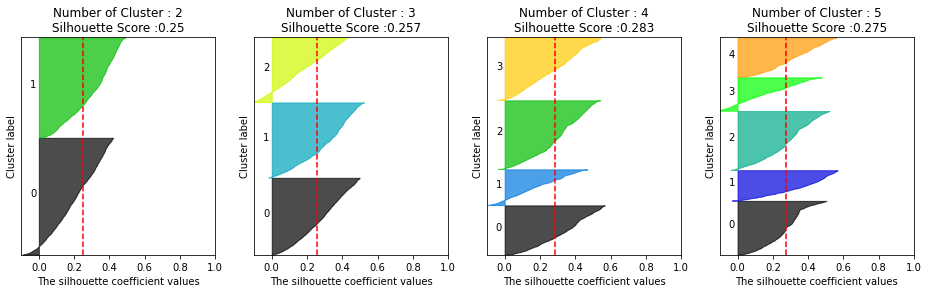

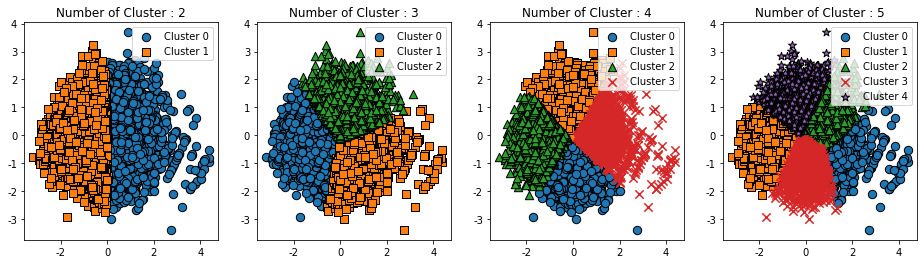

In [43]:
# Clustering
visualize_silhouette([2,3,4,5],sl_w_scaled)
visualize_kmeans_plot_multi([2,3,4,5],sl_w_scaled)

In [44]:
# Silhouette score 산출 및 cluster_label 생성
kmeans=KMeans(n_clusters=4,random_state=0)
labels=kmeans.fit_predict(sl_w_scaled)
sl_w_g['cluster_label']=labels
print('score : {:.3f}'.format(silhouette_score(sl_w_scaled,labels)))
sl_w_g.to_pickle('clustering_women.pkl')
sl_w_g

score : 0.283


,RESIDENCE,AGEGROUP,PURCHAMOUNT,cluster_label
CUSTNO,,,,
6,240,10,2428700,0
7,36,10,19697570,2
16,460,10,428000,3
25,460,10,6966250,0
31,100,10,302600,3
...,...,...,...,...
19349,100,9,376000,3
19362,16,7,4849760,2
19363,100,7,37700,3


In [45]:
# 각 cluster 성향 파악
aggregations={'RESIDENCE':'count',
              'AGEGROUP':'mean',
              'PURCHAMOUNT':'sum'}

d=sl_w_g.groupby('cluster_label').agg(aggregations).sort_values(by='PURCHAMOUNT',ascending=False)
d['RATIO']=(d['PURCHAMOUNT']/d['RESIDENCE'])*100
d.sort_values('RATIO',ascending=False)

,RESIDENCE,AGEGROUP,PURCHAMOUNT,RATIO
cluster_label,,,,
2,2024,7.357708,15406438268,7.611877e+08
0,1447,6.707671,8087216136,5.588954e+08
1,1052,3.919202,1871028150,1.778544e+08
3,1834,7.278081,613731850,3.346411e+07


In [46]:
# 성향 파악을 위한 사용자 함수 생성
def get_a(label,attribution1,attribution2):
    print('##### '+attribution1+' #####')
    print(np.sort(sl_w_g[sl_w_g['cluster_label']==label][attribution1].unique()))
    print()
    print('##### '+attribution2+' #####')
    print(np.sort(sl_w_g[sl_w_g['cluster_label']==label][attribution2].unique()))
    print()
    fig,(ax1,ax2)=plt.subplots(figsize=(12,4),nrows=1,ncols=2)
    ax1.set_title(attribution1+' histogram')
    sns.histplot(sl_w_g[sl_w_g['cluster_label']==label][attribution1],ax=ax1)
    ax2.set_title(attribution2+' histogram')
    sns.histplot(sl_w_g[sl_w_g['cluster_label']==label][attribution2],ax=ax2,bins=7)

##### RESIDENCE #####
[ 13  16  24  30  36  39  45  47  49  52  55  60  65  69  75  82 100 210
 240 270 310 340 360 410 440 460 500 540 570 610]

##### AGEGROUP #####
[ 5  6  7  8  9 10]



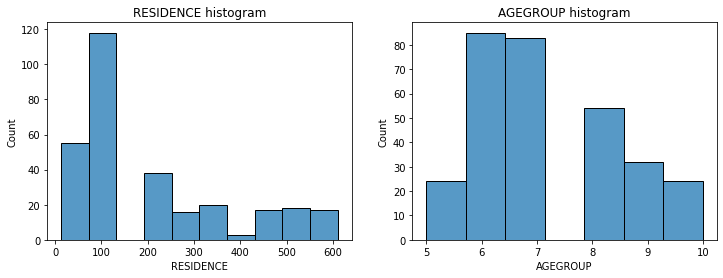

In [71]:
get_a(2,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[210 270 300 310 340 360 410 440 460 500 540 570 610 630]

##### AGEGROUP #####
[ 4  5  6  7  8  9 10]



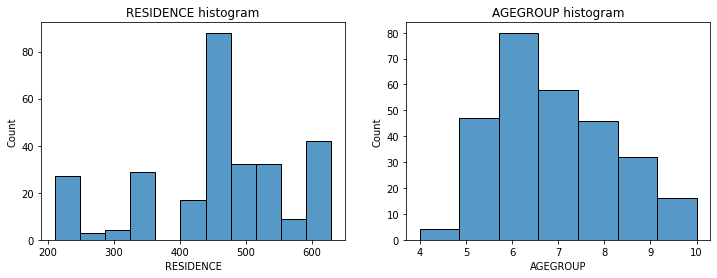

In [72]:
get_a(0,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[ 10  13  16  20  24  27  30  33  36  39  43  45  47  49  52  55  60  65
  69  72  87 100]

##### AGEGROUP #####
[ 4  5  6  7  8  9 10]



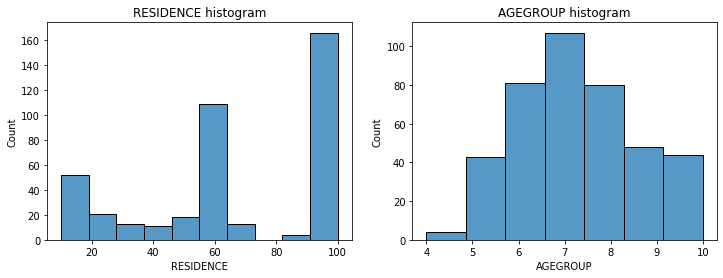

In [73]:
get_a(1,'RESIDENCE','AGEGROUP')

##### RESIDENCE #####
[ 10  13  16  24  33  36  43  47  49  52  55  60  65  75  82  85  87 100
 210 240 270 300 310 340 360 410 440 460 500 540 570 610]

##### AGEGROUP #####
[0 1 3 4 5]



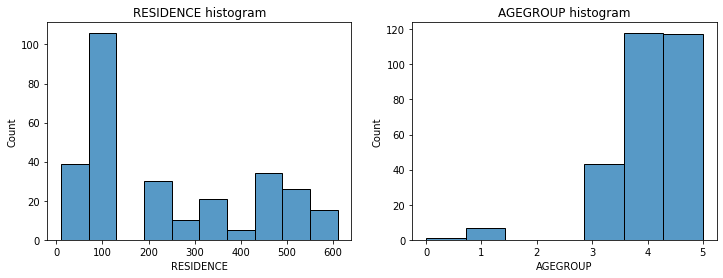

In [74]:
get_a(3,'RESIDENCE','AGEGROUP')